IBTrACS_V4: Uses ds_int, where all storms are calibrated to go from 20 time steps before to t_star (=90% of LMI). 


IBTrACS_V5: All storms go from t34 (=time when storm reached 34 kts) and t_star.

#### Conclusions

- Even when Rmax is never observed, we can reconstruct pretty well Rmax_IBTrACS (mean);

- However, the uncertainty is way too high;

- Overall, CK22 performs better;

- Overall, most storms have a stagnating Rmax once they have reached ~30m/s. We don't capture this. CK22 neither, but is a bit better in this regard.



In [1]:
### IMPORT LIBRARIES

%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize']=(20,20) # graph size

import os

# pandas and statsmodels
import pandas
from statsmodels.stats.weightstats import DescrStatsW

# analog data assimilation
from AnDA_codes.AnDA_generate_data import AnDA_generate_data
from AnDA_codes.AnDA_analog_forecasting import AnDA_analog_forecasting
from AnDA_codes.AnDA_model_forecasting import AnDA_model_forecasting
from AnDA_codes.AnDA_data_assimilation import AnDA_data_assimilation
from AnDA_codes.AnDA_stat_functions import AnDA_RMSE

Populating the interactive namespace from numpy and matplotlib


In [2]:
### DATA
data_dir = '/home/arthur/scripts/TCsLifeMonitFromObs/AnDA/AnDA_data/IBTrACS_V5/'

In [3]:
### IMPORTANT PARAMETERS

### Name and date of the tropical cyclone
# Storms with a low Ck/Cd
TC_name = 'SOUDELOR_2015211N13162'  # SAR ==> Rmax stays around 15km during whole intensification (from 26m/s to 80m/s). GREAT EXAMPLE
# yo.values[15,1] = 15.
# TC_name = 'VAYU_2019160N11073' # SAR ==> Rmax~12km when Vmax~46m/s (1st plateau) then Rmax~43km when Vmax~44m/s just before 2nd plateau and LMI. CK22 predicts this increase, not AnDA.
# TC_name = 'MERANTI_2016253N13144'  # SAR ==> Rmax~33km when Vmax~27m/s then Rmax~12km when Vmax~81m/s. CK22 captures this strong decreasing, AnDA not as much.
# TC_name = 'MANGKHUT_2018250N12170' # SAR ==> Rmax~20km right before LMI (from 70 to 80 m/s)
# TC_name = 'LIONROCK_2016230N25160' # Weird trajectory. SAR ==> Rmax~20 to 25km during int.
# TC_name = 'MINDULLE_2021266N12148' # SAR ==> Rmax~22 when Vmax~62 m/s right before LMI
# TC_name = 'KONG-REY_2018271N06154' # No SAR during int.
# TC_name = 'MEARI_2016305N10147'    # No SAR during int.
# TC_name = 'CEBILE_2018025S09080'   # No SAR during int.
# TC_name = 'HABANA_2021064S16073'   # SAR ==> Rmax goes from 14 to 11km between 1st plateau and 2nd reintensification 

# Storms with a high Ck/Cd:
# TC_name = 'HECTOR_2018213N12245'
# TC_name = 'SERGIO_2018273N12259'   # SAR ==> Rmax doesn't move that much and stays between 35-40km during whole intensification (from 33m/s to 60m/s)
# TC_name = 'LESTER_2016237N14253'   # SAR ==> Rmax doesn't move that much and goes from 29 to 25km during intensification (from 29m/s to 43m/s)
# TC_name = 'JEBI_2018239N11161'     # SAR ==> Rmax~13km when Vmax~34m/s, then Rmax~21km at the end of LMI (77m/s)
# TC_name = 'SAM_2021262N10349'
# TC_name = 'LARRY_2021242N08349'
# TC_name = 'JOANINHA_2019078S13066' # No SAR during int. but 1 image at LMI ==> Rmax~30km at LMI
# TC_name = 'SURIGAE_2021104N08138'  # No SAR during int.
# TC_name = 'DOUGLAS_2020202N15241'  # No SAR during int.
# TC_name = 'HELENE_2018251N13343'   # No SAR during int. but Rmax~50-60km after LMI
# TC_name = 'OMA_2019042S17162'      # Lots of islands and weird trajectory.
# TC_name = 'OLAF_2015288N10243'     # No SAR during int. but Rmax~23km after LMI
# TC_name = 'IGNACIO_2015236N12231'  # SAR ==> Rmax~29km during int. when Vmax~41m/s, then Rmax~17km after LMI
# ==> Overall, for high Ck/Cd, AnDA predicts that Rmax first decreases then stagnates, whereas usually Rmax is already small and stagnates from 34kts to LMI. 
# In this sense, CK22 performs better because it predicts that Rmax stagnates in most cases. 


# number of analogs
nb_analogs = 1000

# variance of the observations
sigma2_obs = 0.05

# index of the first unavailable observation
index_NaN = -1 # 60# TC_name = 'SOUDELOR_2015211N13162'  # SAR ==> Rmax stays around 15km during whole intensification (from 26m/s to 80m/s). GREAT EXAMPLE

In [4]:
### GENERATE THE CATALOG, THE TRUE STATE, AND THE OBSERVATIONS
files = os.listdir(data_dir)
print('Total nb of files: {}'.format(len(files)))

# Create the catalog: put all files except the current one
# Initialization
class catalog:
    IBTrACS_tmp = array(pandas.read_csv(data_dir + files[0], usecols = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']))
    analogs     = IBTrACS_tmp[0:-1,:]
    successors  = IBTrACS_tmp[1:,:]
# Loop over all files (except current one)
for i in arange(1, len(files)):
    if files[i] != TC_name:
        IBTrACS_tmp        = array(pandas.read_csv(data_dir + files[i], usecols = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']))
        catalog.analogs    = concatenate([catalog.analogs, IBTrACS_tmp[0:-1,:]])
        catalog.successors = concatenate([catalog.successors, IBTrACS_tmp[1:,:]])
    else:
        class xt: # Reference
            time   = []
            values = []
        IBTrACS_tmp = array(pandas.read_csv(data_dir + files[i], usecols = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']))
        xt.time     = range(shape(IBTrACS_tmp)[0])
        xt.values   = IBTrACS_tmp
        class yo: # Observations
            time   = []
            values = []
        IBTrACS_tmp = array(pandas.read_csv(data_dir + files[i], usecols = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']))
        yo.time     = range(shape(IBTrACS_tmp)[0])
        yo.values   = IBTrACS_tmp
        yo.values[index_NaN:,] = NaN
        yo.values[:,1] = NaN # remove observations of Rmax
        # yo.values[15,1] = 15.
        
        # yo.values[7:,1] = NaN # remove observations of Rmax

# center and reduce the 6 columns
mean_IBTrACS = mean(catalog.analogs, axis=0)
std_IBTrACS  = std(catalog.analogs, axis=0)
for j in range(shape(catalog.analogs)[1]):
    catalog.analogs[:,j]    = (catalog.analogs[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    catalog.successors[:,j] = (catalog.successors[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    xt.values[:,j] = (xt.values[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    yo.values[:,j] = (yo.values[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]

Total nb of files: 383


In [5]:
### ANALOG DATA ASSIMILATION (dynamical model given by the catalog)

def normze(x):
    return (x - mean_IBTrACS) / std_IBTrACS
def inv_normze(x):
    return (x * std_IBTrACS) + mean_IBTrACS

n = shape(catalog.analogs)[1]

# parameters of the analog forecasting method
class AF:
    k            = nb_analogs # number of analogs
    neighborhood = np.ones(n) # global analogs
    catalog      = catalog # catalog with analogs and successors
    regression   = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
    sampling     = 'gaussian' # chosen sampler ('gaussian', 'multinomial')

# parameters of the filtering method
class DA:
    method = 'AnEnKS' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N      = 1000 # number of members (AnEnKF/AnEnKS) or parti8-10-cles (AnPF)
    xb     = xt.values[0,:]; B = np.eye(n)
    H      = np.eye(n)
    R      = sigma2_obs * np.eye(n)
    @staticmethod
    def m(x):
#         # x is shape (1000, 6)
#         # x_out is shape (2, 1000, 6)
#         x_out          = zeros((2, DA.N, n)) # 1st term are the particules, 2nd term is the mean
#         x_out[:, :, :] = AnDA_analog_forecasting(x, AF)
        
#         # Un-normalize 
#         x     = inv_normze(x)
#         x_out = inv_normze(x_out)
#         # Rmax regularization
#         # reglze         = mean(x[:, 1]) / mean(x[:, 0]) # Rmax/Vmax
#         # reglze         = 17.5 / mean(x[:, 0])
#         if mean(x[:, 0]) < 30:
#             reglze = 0.5
#         else:
#             reglze = 0
#         # reglze         = min(reglze, 0.9)
#         # print(mean(x[:, 0]))
#         # print(reglze)
#         # x_out[0, :, 1] = where(x_out[0, :, 1] > x[:, 1], (1 + reglze) * (x[:, 1] / x_out[0, :, 1]), (1 - reglze) * (x[:, 1] / x_out[0, :, 1])) * x_out[0, :, 1]
#         x_out[0, :, 1] = where(x_out[0, :, 1] > mean(x[:, 1]), (1 + reglze) * (mean(x[:, 1]) / x_out[0, :, 1]), (1 - reglze) * (mean(x[:, 1]) / x_out[0, :, 1])) * x_out[0, :, 1]
#         x_out[1, :, 1] = mean(x_out[0, :, 1])
        
#         # Normalize
#         x_out = normze(x_out)

#         return x_out
        return AnDA_analog_forecasting(x, AF)
    
# run the analog data assimilation
x_hat_analog = AnDA_data_assimilation(yo, DA)

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 92.76it/s]


In [10]:
# x = inv_normze(x_hat_analog.part)
# print(x.shape)
# fig = plt.subplots(figsize=(20, 10))
# for p in range(0, 100):
#     plt.plot(x[:, p, 1])

In [7]:
# compute weighted quantiles
x_hat_analog_quantiles = zeros([shape(x_hat_analog.part)[0], 7, n])
for t in range(shape(x_hat_analog.part)[0]):
    for j in range(n):
        wq = DescrStatsW(data=x_hat_analog.part[t,:,j], weights=x_hat_analog.weights[t,:])
        x_hat_analog_quantiles[t,:,j] = wq.quantile(probs=np.array([0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]), return_pandas=False)

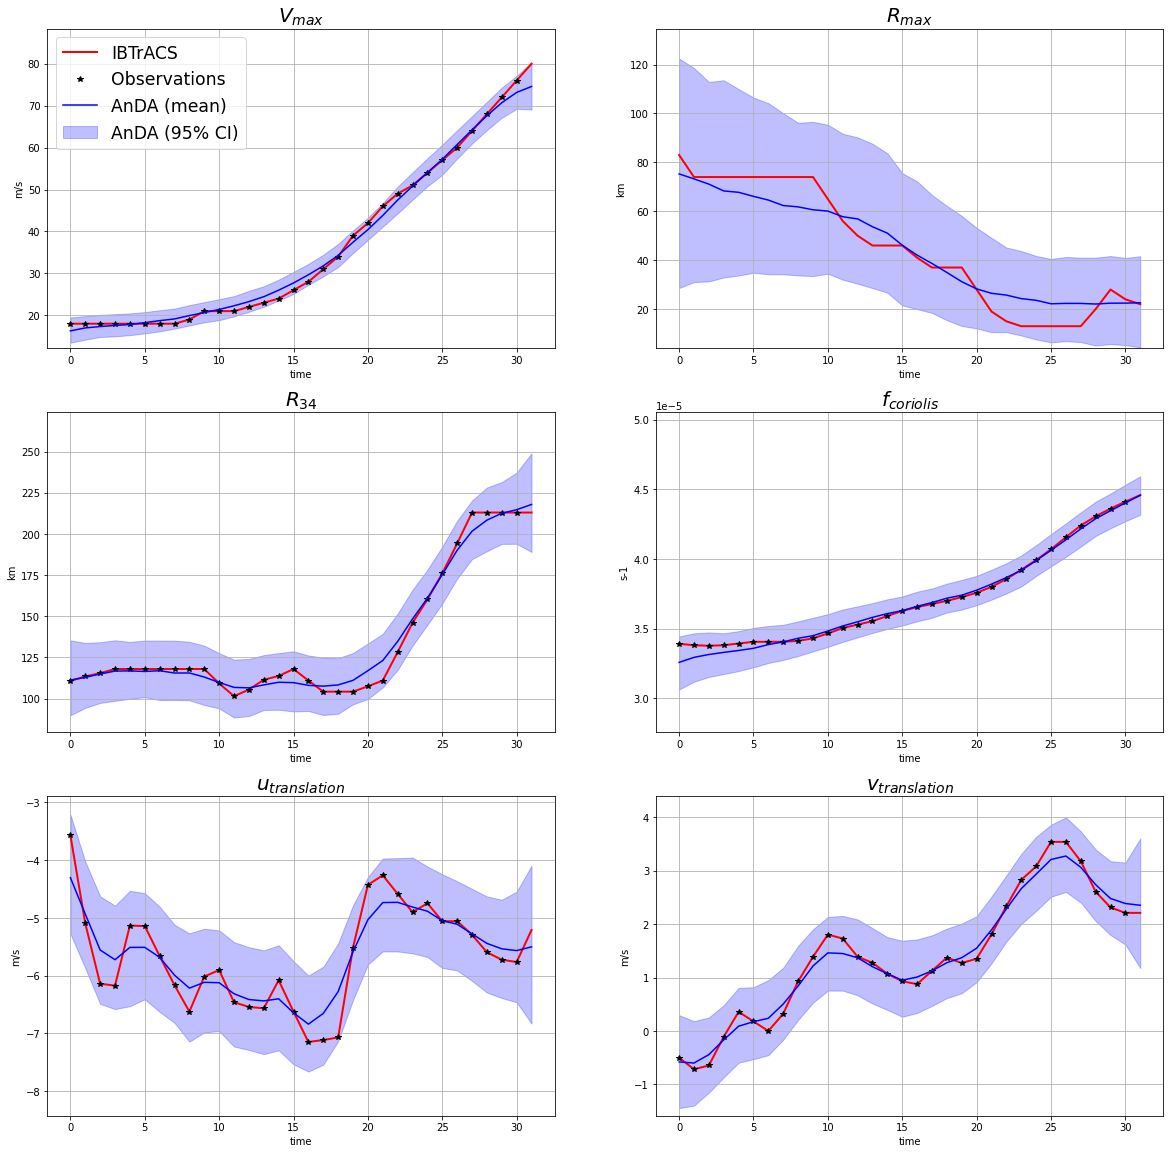

In [8]:
### Plot Vmax, Rmax, R34, f, U, V
tab_title = ['$V_{max}$', '$R_{max}$', '$R_{34}$', '$f_{coriolis}$', '$u_{translation}$', '$v_{translation}$']
plt_legds = [['time', 'm/s'], ['time', 'km'], ['time', 'km'], ['time', 's-1'], ['time', 'm/s'], ['time', 'm/s']]

# Define plot limits
q025_lims = [[min(x_hat_analog_quantiles[:, 0, j] * std_IBTrACS[j] + mean_IBTrACS[j]), max(x_hat_analog_quantiles[:, 0, j] * std_IBTrACS[j] + mean_IBTrACS[j])] for j in range(xt.values.shape[1])]
q975_lims = [[min(x_hat_analog_quantiles[:, 6, j] * std_IBTrACS[j] + mean_IBTrACS[j]), max(x_hat_analog_quantiles[:, 6, j] * std_IBTrACS[j] + mean_IBTrACS[j])] for j in range(yo.values.shape[1])]
y_lims    = [[np.nanmin((q025_lim[0], q975_lim[0])), np.nanmax((q025_lim[1], q975_lim[1]))] for q025_lim, q975_lim in zip(q025_lims, q975_lims)]
for idx, (left, right) in enumerate(y_lims):
    if left > 0:
        y_lims[idx][0] *= 0.9
    else:
        y_lims[idx][0] *= 1.1
    if right > 0:
        y_lims[idx][1] *= 1.1
    else:
        y_lims[idx][1] *= 0.9

# Plot
for j in range(n):
    subplot(3,2,j+1)
    plot(xt.time, xt.values[:, j] * std_IBTrACS[j] + mean_IBTrACS[j], '-r', linewidth=2)
    plot(yo.time, yo.values[:, j] * std_IBTrACS[j] + mean_IBTrACS[j], '*k')
    plot(yo.time, x_hat_analog_quantiles[:, 3, j] * std_IBTrACS[j] + mean_IBTrACS[j], '-b')
    grid()
    xlabel(plt_legds[j][0]);ylabel(plt_legds[j][1])
    fill_between(x_hat_analog.time, x_hat_analog_quantiles[:, 0, j] * std_IBTrACS[j] + mean_IBTrACS[j], x_hat_analog_quantiles[:, 6, j] * std_IBTrACS[j] + mean_IBTrACS[j], alpha=0.25, color='b')
    ylim(y_lims[j])
    title(tab_title[j], size=20)
    if j==0:
        legend(['IBTrACS', 'Observations', 'AnDA (mean)', 'AnDA (95% CI)'], loc=0, fontsize='xx-large')

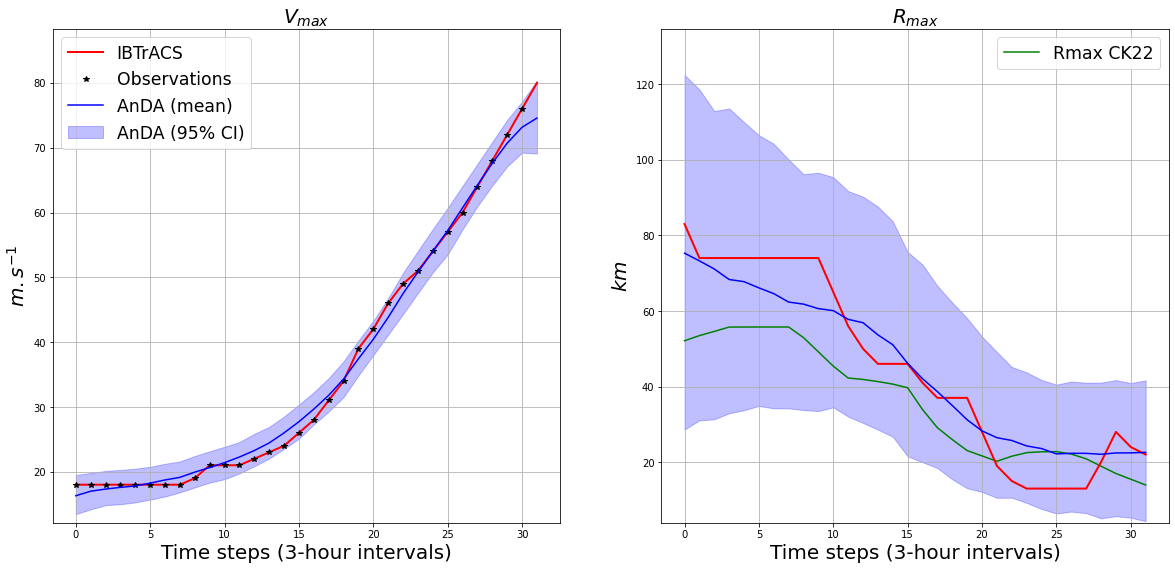

In [9]:
# focus on Vmax and Rmax (DECODages presentation)

tab_title  = ['$V_{max}$', '$R_{max}$']
tab_ylabel = ['$m.s^{-1}$', '$km$']
y_lims     = y_lims[:2]

for i in arange(1, len(files)):
    if files[i] == TC_name:
        IBTrACS_crt = array(pandas.read_csv(data_dir + files[i], usecols = ['Vmax', 'Rmax_IBT', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']))

# plot
for j in range(2):
    subplot(2,2,j+1)
    if j==1:
        plot(xt.time, IBTrACS_crt[:,2], '-g')
    plot(xt.time, xt.values[:,j] * std_IBTrACS[j] + mean_IBTrACS[j], '-r', linewidth=2)
    plot(yo.time, yo.values[:,j] * std_IBTrACS[j] + mean_IBTrACS[j], '*k')
    plot(yo.time, x_hat_analog_quantiles[:,3,j] * std_IBTrACS[j] + mean_IBTrACS[j], '-b')
    fill_between(x_hat_analog.time, x_hat_analog_quantiles[:,0,j] * std_IBTrACS[j] + mean_IBTrACS[j], x_hat_analog_quantiles[:,6,j] * std_IBTrACS[j] + mean_IBTrACS[j], alpha=0.25, color='b')
    ylim(y_lims[j])
    title(tab_title[j], size=20)
    xlabel('Time steps (3-hour intervals)', size=20)
    ylabel(tab_ylabel[j], size=20)
    grid()
    if j==0:
        legend(['IBTrACS', 'Observations', 'AnDA (mean)', 'AnDA (95% CI)'], loc=0, fontsize='xx-large')
    if j==1:
        legend(['Rmax CK22'], loc=0, fontsize='xx-large')